# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import math

## PyQrack

In [3]:
from pyqrack import QrackSimulator


def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while start < end:
        sim.swap(start, end)
        start += 1
        end -= 1


def qrack_qft(sim, n):
    sim.iqft([i for i in reversed(range(n))])
    reverse_qrack(sim)
    sim.m_all()

### |0> initialization

In [4]:
def bench_0_qrack(n):
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    sim = QrackSimulator(n, isTensorNetwork=False)
    qrack_qft(sim, n)

    return time.perf_counter() - start


# Load OpenCL to avoid 1-sample discontinuity:
bench_0_qrack(12)

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qrack(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 2.9999299999872165e-05, 2: 0.00010792220000297448, 3: 0.0002968008000024724, 4: 0.0003406042000023035, 5: 0.0004348833999998192, 6: 0.0006352286000023355, 7: 0.0008177755000005505, 8: 0.0010445810999996751, 9: 0.001365972500001078, 10: 0.0016947903999991354, 11: 0.0028423766999964074, 12: 0.003848876899999709, 13: 0.004881669200001682, 14: 0.006165032999996356, 15: 0.007556179399999507, 16: 0.00852050310000152, 17: 0.009793274899998039, 18: 0.010618841800000212, 19: 0.012150198900002351, 20: 0.013914573599998903, 21: 0.01666505539999861, 22: 0.021795075800000063, 23: 0.028208967999999855, 24: 0.038446982899999683, 25: 0.060704126599999596, 26: 0.10256509010000059, 27: 0.17737714190000134}


### GHZ state initialization

In [5]:
def bench_ghz_qrack(n):
    start = time.perf_counter()
    sim = QrackSimulator(n, isTensorNetwork=False)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    qrack_qft(sim, n)

    return time.perf_counter() - start


qrack_ghz_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qrack(n))

    qrack_ghz_results[n] = sum(width_results) / samples

print(qrack_ghz_results)

{1: 6.166490000083513e-05, 2: 0.00012085479999939253, 3: 0.00023269579999833921, 4: 0.00036728250000379604, 5: 0.000558005700000308, 6: 0.0007506579999983388, 7: 0.000904315999999028, 8: 0.0011999380999995423, 9: 0.0015321421999956897, 10: 0.002031096000003174, 11: 0.004843737400000237, 12: 0.00577777980000036, 13: 0.00668398249999882, 14: 0.007705127899998843, 15: 0.008992710899998712, 16: 0.010141251400000328, 17: 0.011201368099997921, 18: 0.012644506400000921, 19: 0.014708113800001855, 20: 0.019403999899998324, 21: 0.027403327200001115, 22: 0.04206905690000014, 23: 0.07145223039999848, 24: 0.1284269727999984, 25: 0.24636103590000005, 26: 0.4896414710999991, 27: 0.994291849699998}


## FFTW ("Classical" DFT)

In [6]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)

### |0> initialization

In [7]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        start = time.perf_counter()
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.0
        pyfftw.interfaces.numpy_fft.fft(
            io_array, overwrite_input=True, threads=(16 if (n > 20) else 1)
        )
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 6.063219999958846e-05, 2: 4.4949299999075264e-05, 3: 3.503310000070314e-05, 4: 1.944689999930915e-05, 5: 3.1449899999813624e-05, 6: 2.0466399993779306e-05, 7: 3.1530299996518354e-05, 8: 2.7938900001345245e-05, 9: 2.7246899996669072e-05, 10: 2.3717399999156895e-05, 11: 2.678770000272834e-05, 12: 4.405939999969632e-05, 13: 6.527789999921652e-05, 14: 0.00010723209999952132, 15: 0.0001743611000037504, 16: 0.00042193650000257323, 17: 0.0008306685000007974, 18: 0.0018724359999993112, 19: 0.007843453900001407, 20: 0.015594958200000519, 21: 0.013928444500000126, 22: 0.04156898349999949, 23: 0.08736028999999945, 24: 0.1772167855999996, 25: 0.37678491360000094, 26: 0.8778312428999996, 27: 1.8306940407000014}


### GHZ initialization

In [8]:
fftw_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        start = time.perf_counter()
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.0 / math.sqrt(2.0)
        io_array[(1 << n) - 1] = 1.0 / math.sqrt(2.0)
        pyfftw.interfaces.numpy_fft.fft(
            io_array, overwrite_input=True, threads=(16 if (n > 20) else 1)
        )
        width_results.append(time.perf_counter() - start)

    fftw_ghz_results[n] = sum(width_results) / samples

print(fftw_ghz_results)

{1: 3.3777599998074945e-05, 2: 2.5535700001455552e-05, 3: 2.3169199997141733e-05, 4: 2.3050400002944116e-05, 5: 2.385360000118908e-05, 6: 2.534619999892129e-05, 7: 8.760300000005827e-05, 8: 2.275599999848055e-05, 9: 2.3652500001958287e-05, 10: 2.5171999996587147e-05, 11: 2.916139999626921e-05, 12: 3.9602799998306185e-05, 13: 6.497989999161291e-05, 14: 0.00010258000000646916, 15: 0.0001618292999978621, 16: 0.0003446163999996088, 17: 0.0006830749000016567, 18: 0.0014640920999994477, 19: 0.007010402699995666, 20: 0.015528732600000695, 21: 0.012220207299998264, 22: 0.0396755689999992, 23: 0.08478616899999736, 24: 0.17293241319999594, 25: 0.3703874301000013, 26: 0.863015500200001, 27: 1.7719886832999976}


## Qiskit Aer

In [9]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator


def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while start < end:
        circ.swap(start, end)
        start += 1
        end -= 1


# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def aer_qft(n, circuit):
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        circuit.cp(math.pi / 2 ** (n - qubit), qubit, n)

    # Recursive QFT is very similiar to a ("classical") FFT
    aer_qft(n, circuit)


sim_backend = AerSimulator(shots=1)

### |0> initialization

In [10]:
def bench_0_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)
    start = time.perf_counter()
    job = sim_backend.run([circ], timeout=600)
    job.result()
    return time.perf_counter() - start


aer_0_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_aer(n))

    aer_0_results[n] = sum(width_results) / samples

print(aer_0_results)

{1: 0.0007978134999945041, 2: 0.000787726100000441, 3: 0.0007250556000030883, 4: 0.0009195389999973713, 5: 0.0010954395000084105, 6: 0.001530113300000835, 7: 0.0017923175999953855, 8: 0.002173971499996696, 9: 0.0026249310999901356, 10: 0.003523034200000552, 11: 0.004435922900003675, 12: 0.005897725799999876, 13: 0.008118782900004362, 14: 0.012202733299997704, 15: 0.01205640530000096, 16: 0.015037464200000272, 17: 0.01995129760000509, 18: 0.028659010899997384, 19: 0.04698382340000364, 20: 0.08558156220000228, 21: 0.18360243430000195, 22: 0.39875451019999275, 23: 0.8734318356000017, 24: 1.835475868499995, 25: 3.913820125199996, 26: 8.803666093100002, 27: 17.4470143457}


### GHZ initialization

In [11]:
def bench_ghz_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    circ.h(0)
    for i in range(1, n):
        circ.cx(0, i)
    aer_qft(num_qubits, circ)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)
    start = time.perf_counter()
    job = sim_backend.run([circ], timeout=600)
    job.result()
    return time.perf_counter() - start


aer_ghz_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_aer(n))

    aer_ghz_results[n] = sum(width_results) / samples

print(aer_ghz_results)

{1: 0.0005263307000063832, 2: 0.0006169418000126825, 3: 0.0007648399000004247, 4: 0.0010795352999821261, 5: 0.0014003192000132004, 6: 0.0018450856000072236, 7: 0.002247398700001213, 8: 0.002712480399998185, 9: 0.003309722199992393, 10: 0.004083340599993335, 11: 0.004902116699975067, 12: 0.0062636140999984494, 13: 0.008538983800008282, 14: 0.012935187499999756, 15: 0.012234738100016785, 16: 0.016129220999982864, 17: 0.043163787800017415, 18: 0.040244019499982644, 19: 0.05426339560000315, 20: 0.10078856589997258, 21: 0.21776113769999483, 22: 0.469005521400004, 23: 0.9976255996999839, 24: 2.1537349872999925, 25: 4.53137663870001, 26: 9.650399566699969, 27: 20.223975013500013}


## Qulacs

In [12]:
import qulacs


def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while start < end:
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1


def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1.0, np.exp(1.0j * np.pi * exponent)])


# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def qulacs_qft(n, circ):
    if n == 0:
        return circ
    n -= 1

    circ.add_gate(qulacs.gate.H(n))
    for qubit in range(n):
        mat = get_rotz(math.pi / 2 ** (n - qubit))
        gate = qulacs.gate.DenseMatrix(n, mat)
        gate.add_control_qubit(qubit, 1)
        circ.add_gate(gate)

    # Recursive QFT is very similiar to a ("classical") FFT
    qulacs_qft(n, circ)

### |0> initialization

In [13]:
def bench_0_qulacs(n):
    start = time.perf_counter()

    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    qulacs_qft(n, circ)
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))
    circ.update_quantum_state(sim)

    return time.perf_counter() - start


qulacs_0_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qulacs(n))

    qulacs_0_results[n] = sum(width_results) / samples

print(qulacs_0_results)

{1: 0.020847933800018835, 2: 0.0009593306000056145, 3: 0.0004831225999851085, 4: 0.0006579804000011791, 5: 0.0008669927999903848, 6: 0.0009985401999983879, 7: 0.0012362635999920712, 8: 0.0014742521000016494, 9: 0.0017810647999908723, 10: 0.0022300679999602835, 11: 0.00277904799999078, 12: 0.003493849100004809, 13: 0.004297532599980514, 14: 0.005567506399995636, 15: 0.008563271100024394, 16: 0.020103815000038595, 17: 0.05087585700000545, 18: 0.1134478424000008, 19: 0.2263230010999905, 20: 0.4533115330000214, 21: 0.9277278929000203, 22: 1.7912971869000216, 23: 3.895161091500017, 24: 7.541484330699984, 25: 15.271679208399974, 26: 29.879229318499984, 27: 63.05996332529994}


### GHZ initialization

In [14]:
def bench_ghz_qulacs(n):
    start = time.perf_counter()

    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)

    circ.add_gate(qulacs.gate.H(0))
    for i in range(1, n):
        circ.add_gate(qulacs.gate.CNOT(0, i))

    qulacs_qft(n, circ)
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start


qulacs_ghz_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qulacs(n))

    qulacs_ghz_results[n] = sum(width_results) / samples

print(qulacs_ghz_results)

{1: 0.00123965410002711, 2: 0.0013734536000356457, 3: 0.0015837729000395483, 4: 0.0018086738000420155, 5: 0.0015985540999736258, 6: 0.0011581846000353834, 7: 0.0013498054000137926, 8: 0.0016442097999970428, 9: 0.0019171186001130992, 10: 0.002315422499941633, 11: 0.002917433500078914, 12: 0.003848161199948663, 13: 0.004434919800041825, 14: 0.005656391700040331, 15: 0.008671496100032528, 16: 0.019803436399979547, 17: 0.050194931600026395, 18: 0.11089581409996754, 19: 0.22794838919999166, 20: 0.45523414989997946, 21: 0.9057025146000341, 22: 1.9045377440999345, 23: 3.6955476737000934, 24: 7.6886391912000365, 25: 15.30206380300001, 26: 29.974363401399977, 27: 61.21254213040002}


## QCGPU

In [15]:
import qcgpu


def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)


def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while start < end:
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1


# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def qcgpu_qft(n, circuit):
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(qubit, n, math.pi / 2 ** (n - qubit))

    # Recursive QFT is very similiar to a ("classical") FFT
    qcgpu_qft(n, circuit)

/home/iamu/qrack_venv_3-12/lib/python3.12/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


### |0> initialization

In [16]:
def bench_0_qcgpu(num_qubits):
    start = time.perf_counter()
    state = qcgpu.State(num_qubits)
    qcgpu_qft(num_qubits, state)
    reverse_qcgpu(num_qubits, state)
    state.measure()
    state.backend.queue.finish()

    return time.perf_counter() - start


qcgpu_0_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qcgpu(n))

    qcgpu_0_results[n] = sum(width_results) / samples

print(qcgpu_0_results)

{1: 0.013266436899994006, 2: 0.0018073733000619542, 3: 0.0020318741000664884, 4: 0.0035913129000618937, 5: 0.004774090299906675, 6: 0.0065292899999803925, 7: 0.00807251209998867, 8: 0.010365693500079941, 9: 0.012395436700035133, 10: 0.015217586600056166, 11: 0.01778811950007366, 12: 0.021035331199982465, 13: 0.024114783400045782, 14: 0.027971226800036674, 15: 0.03175788349990398, 16: 0.036156507299938315, 17: 0.040864970500115304, 18: 0.047155896099957316, 19: 0.05470463620008559, 20: 0.06603236179994383, 21: 0.08464289879998432, 22: 0.11486082330006867, 23: 0.18061740649995955, 24: 0.37116838079987247, 25: 0.7660125332999541, 26: 1.5884065153999927, 27: 3.2914352020999105}


### GHZ initialization

In [17]:
def bench_ghz_qcgpu(num_qubits):
    start = time.perf_counter()
    state = qcgpu.State(num_qubits)
    state.h(0)
    for i in range(1, num_qubits):
        state.cnot(0, i)
    qcgpu_qft(num_qubits, state)
    reverse_qcgpu(num_qubits, state)
    state.measure()
    state.backend.queue.finish()

    return time.perf_counter() - start


qcgpu_ghz_results = {}
for n in range(low, high + 1):
    width_results = []

    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qcgpu(n))

    qcgpu_ghz_results[n] = sum(width_results) / samples

print(qcgpu_ghz_results)

{1: 0.0017023079999034963, 2: 0.002045869500079789, 3: 0.002749745700020867, 4: 0.004360996900049941, 5: 0.005730950399993162, 6: 0.007555153299927042, 7: 0.009385621100000208, 8: 0.011828510399936931, 9: 0.01407807500013405, 10: 0.017056727600038357, 11: 0.019810675500048093, 12: 0.023331427800076198, 13: 0.026651823300016985, 14: 0.030807441800061498, 15: 0.03460622480001803, 16: 0.03945650999999088, 17: 0.044288767399984864, 18: 0.050896043700004154, 19: 0.05833681760000218, 20: 0.07016552400004912, 21: 0.08897602800007007, 22: 0.12038155300001563, 23: 0.1891748290999203, 24: 0.38866527939999285, 25: 0.8040122308999799, 26: 1.6637437185999715, 27: 3.4422979606000355}


## qsimcirq

### |0> initialization

In [18]:
# See ../scripts/qsimcirq_qft.py
# We run that file on the cuQuantum appliance.

qsimcirq_0_results = {
    1: 0.01834163589956006,
    2: 0.002489976600918453,
    3: 0.0024933346001489555,
    4: 0.0025116001994319958,
    5: 0.0026075902995216895,
    6: 0.0027329972992447436,
    7: 0.0029121678999217693,
    8: 0.0031690389998402678,
    9: 0.0032865634002519073,
    10: 0.003572094599803677,
    11: 0.0038015081991034094,
    12: 0.004102939500808134,
    13: 0.004368573800093145,
    14: 0.004703629800133058,
    15: 0.005062727100448683,
    16: 0.005431754600431304,
    17: 0.005891501299265656,
    18: 0.006582004799929564,
    19: 0.008336337699438446,
    20: 0.015291518200319843,
    21: 0.02588589070037415,
    22: 0.048212399900148736,
    23: 0.09627932500006864,
    24: 0.20019321759973535,
    25: 0.4202082566996978,
    26: 0.894700813000236,
    27: 1.9162632411993399,
}
print(qsimcirq_0_results)

{1: 0.01834163589956006, 2: 0.002489976600918453, 3: 0.0024933346001489555, 4: 0.0025116001994319958, 5: 0.0026075902995216895, 6: 0.0027329972992447436, 7: 0.0029121678999217693, 8: 0.0031690389998402678, 9: 0.0032865634002519073, 10: 0.003572094599803677, 11: 0.0038015081991034094, 12: 0.004102939500808134, 13: 0.004368573800093145, 14: 0.004703629800133058, 15: 0.005062727100448683, 16: 0.005431754600431304, 17: 0.005891501299265656, 18: 0.006582004799929564, 19: 0.008336337699438446, 20: 0.015291518200319843, 21: 0.02588589070037415, 22: 0.048212399900148736, 23: 0.09627932500006864, 24: 0.20019321759973535, 25: 0.4202082566996978, 26: 0.894700813000236, 27: 1.9162632411993399}


### GHZ initialization

In [19]:
# See ../scripts/qsimcirq_qft.py
# We run that file on the cuQuantum appliance.

qsimcirq_ghz_results = {
    1: 0.004183252999791875,
    2: 0.0023900775002402954,
    3: 0.002466993799316697,
    4: 0.0026304522001737497,
    5: 0.002747449400339974,
    6: 0.002899418900051387,
    7: 0.003092963999370113,
    8: 0.0033462461997260107,
    9: 0.0035934398998506366,
    10: 0.003881338499923004,
    11: 0.00417660789898946,
    12: 0.004587883999556652,
    13: 0.0048757333988760365,
    14: 0.005223927000042749,
    15: 0.005597093800679432,
    16: 0.006029916299667093,
    17: 0.006492829000490019,
    18: 0.00730068550001306,
    19: 0.009185781100313761,
    20: 0.016773435000141036,
    21: 0.028172302600069088,
    22: 0.05234916799963685,
    23: 0.10394735789959668,
    24: 0.21538212099912926,
    25: 0.45062218380007835,
    26: 0.9565895882005861,
    27: 2.0435318315001494,
}
print(qsimcirq_ghz_results)

{1: 0.004183252999791875, 2: 0.0023900775002402954, 3: 0.002466993799316697, 4: 0.0026304522001737497, 5: 0.002747449400339974, 6: 0.002899418900051387, 7: 0.003092963999370113, 8: 0.0033462461997260107, 9: 0.0035934398998506366, 10: 0.003881338499923004, 11: 0.00417660789898946, 12: 0.004587883999556652, 13: 0.0048757333988760365, 14: 0.005223927000042749, 15: 0.005597093800679432, 16: 0.006029916299667093, 17: 0.006492829000490019, 18: 0.00730068550001306, 19: 0.009185781100313761, 20: 0.016773435000141036, 21: 0.028172302600069088, 22: 0.05234916799963685, 23: 0.10394735789959668, 24: 0.21538212099912926, 25: 0.45062218380007835, 26: 0.9565895882005861, 27: 2.0435318315001494}


## Qiskit cusvaer (single precision)

### |0> initialization

In [20]:
# See ../scripts/qiskit_cusvaer_qft.py
# We run that file on the cuQuantum appliance.

cusvaer_0_results = {
    1: 0.18439941850047034,
    2: 0.0026285579006071202,
    3: 0.00259038800104463,
    4: 0.0025546452998241875,
    5: 0.002647374300067895,
    6: 0.0027162945007148664,
    7: 0.0027635991002171066,
    8: 0.003008444500301266,
    9: 0.003254579400163493,
    10: 0.0036589807004929753,
    11: 0.0041345065994391915,
    12: 0.004489938000187976,
    13: 0.005067081399465679,
    14: 0.005888461200083839,
    15: 0.006659435700203176,
    16: 0.006213472999297665,
    17: 0.0065818693998153325,
    18: 0.007102208599462756,
    19: 0.00784919620018627,
    20: 0.008722250999198877,
    21: 0.009412747200258309,
    22: 0.012423190800109295,
    23: 0.02147944149983232,
    24: 0.041370984700188275,
    25: 0.08033599460068216,
    26: 0.16478043500064815,
    27: 0.3361863972997526,
}
print(cusvaer_0_results)

{1: 0.18439941850047034, 2: 0.0026285579006071202, 3: 0.00259038800104463, 4: 0.0025546452998241875, 5: 0.002647374300067895, 6: 0.0027162945007148664, 7: 0.0027635991002171066, 8: 0.003008444500301266, 9: 0.003254579400163493, 10: 0.0036589807004929753, 11: 0.0041345065994391915, 12: 0.004489938000187976, 13: 0.005067081399465679, 14: 0.005888461200083839, 15: 0.006659435700203176, 16: 0.006213472999297665, 17: 0.0065818693998153325, 18: 0.007102208599462756, 19: 0.00784919620018627, 20: 0.008722250999198877, 21: 0.009412747200258309, 22: 0.012423190800109295, 23: 0.02147944149983232, 24: 0.041370984700188275, 25: 0.08033599460068216, 26: 0.16478043500064815, 27: 0.3361863972997526}


### GHZ initialization

In [21]:
# See ../scripts/qiskit_cusvaer_qft.py
# We run that file on the cuQuantum appliance.

cusvaer_ghz_results = {
    1: 0.004869429700920591,
    2: 0.0025734786002431067,
    3: 0.002523883199683041,
    4: 0.002494549700350035,
    5: 0.0025488962011877446,
    6: 0.002583526699891081,
    7: 0.002811101599581889,
    8: 0.002968087900080718,
    9: 0.0033019851995049975,
    10: 0.0036881656997138634,
    11: 0.004179826499967021,
    12: 0.004547124699820415,
    13: 0.005192450899994583,
    14: 0.0059118558994669,
    15: 0.00677864010031044,
    16: 0.00621048319953843,
    17: 0.006583194899940281,
    18: 0.007150053000441403,
    19: 0.008061760499913362,
    20: 0.008797047999905772,
    21: 0.009498510601042653,
    22: 0.012433452499681152,
    23: 0.02161339570047858,
    24: 0.04014889779937221,
    25: 0.08031232589964929,
    26: 0.16489839300011228,
    27: 0.336063055699924,
}
print(cusvaer_ghz_results)

{1: 0.004869429700920591, 2: 0.0025734786002431067, 3: 0.002523883199683041, 4: 0.002494549700350035, 5: 0.0025488962011877446, 6: 0.002583526699891081, 7: 0.002811101599581889, 8: 0.002968087900080718, 9: 0.0033019851995049975, 10: 0.0036881656997138634, 11: 0.004179826499967021, 12: 0.004547124699820415, 13: 0.005192450899994583, 14: 0.0059118558994669, 15: 0.00677864010031044, 16: 0.00621048319953843, 17: 0.006583194899940281, 18: 0.007150053000441403, 19: 0.008061760499913362, 20: 0.008797047999905772, 21: 0.009498510601042653, 22: 0.012433452499681152, 23: 0.02161339570047858, 24: 0.04014889779937221, 25: 0.08031232589964929, 26: 0.16489839300011228, 27: 0.336063055699924}


## Results

### |0> initialization

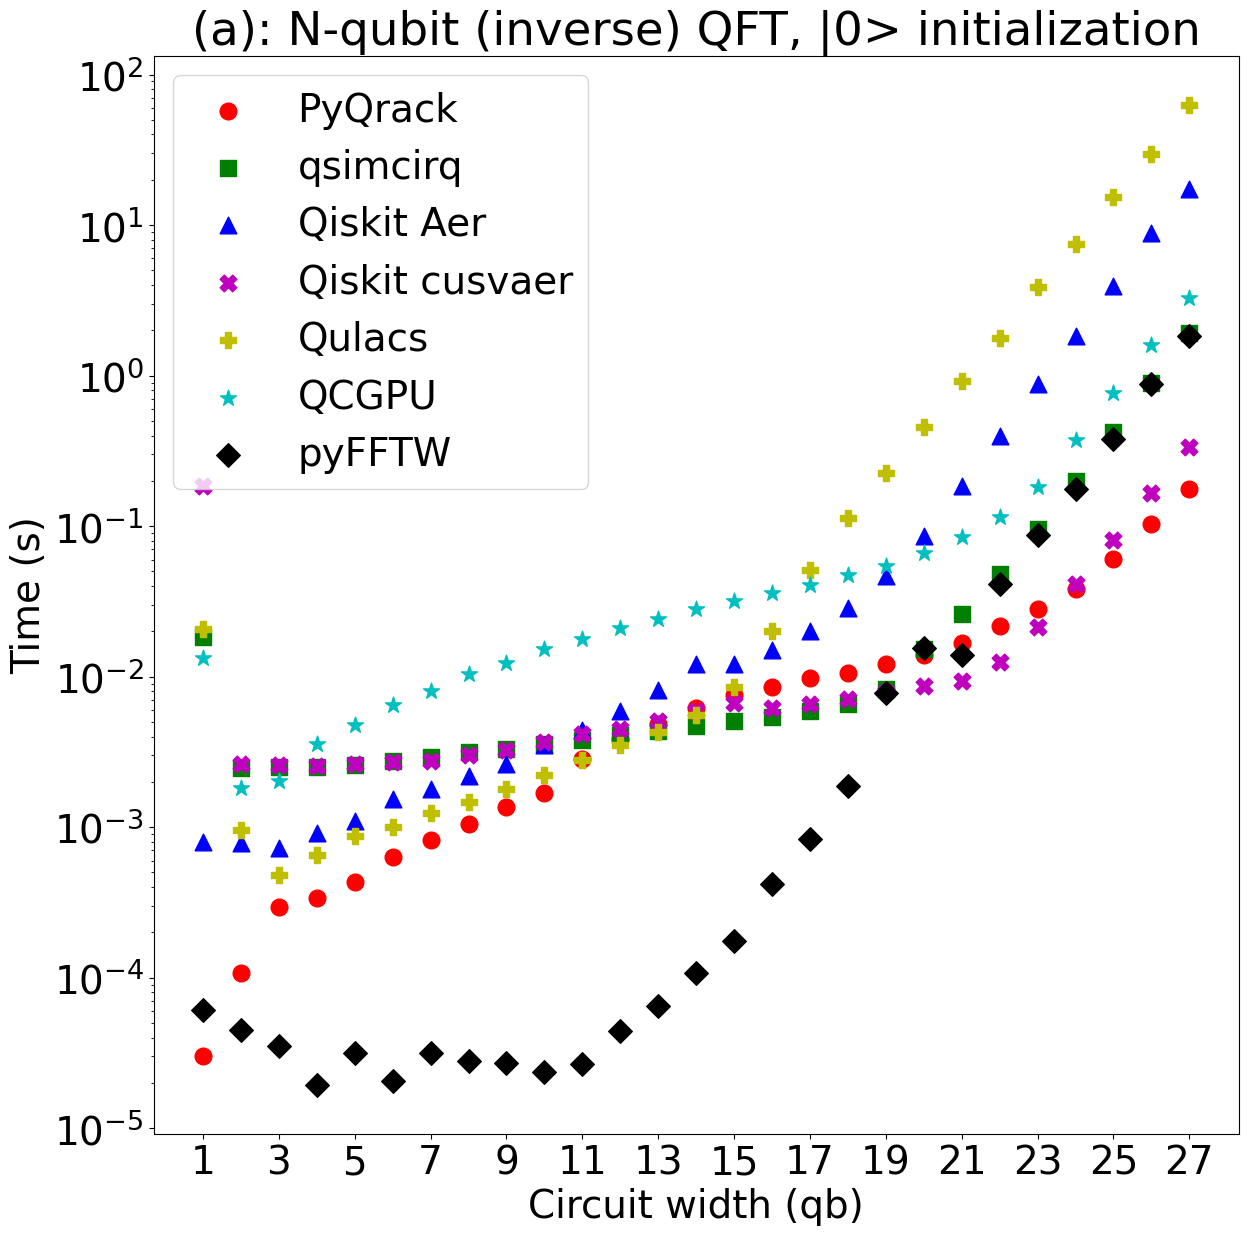

In [22]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc("legend", fontsize=28)
plt.rcParams.update({"font.size": 28, "lines.markersize": 12})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qsimcirq_0_results.keys()
y = qsimcirq_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = aer_0_results.keys()
y = aer_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = cusvaer_0_results.keys()
y = cusvaer_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qulacs_0_results.keys()
y = qulacs_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qcgpu_0_results.keys()
y = qcgpu_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

plt.title("(a): N-qubit (inverse) QFT, |0> initialization")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack", "qsimcirq", "Qiskit Aer", "Qiskit cusvaer", "Qulacs", "QCGPU", "pyFFTW"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig("qft_0_chart.png", dpi=100)

### GHZ initialization

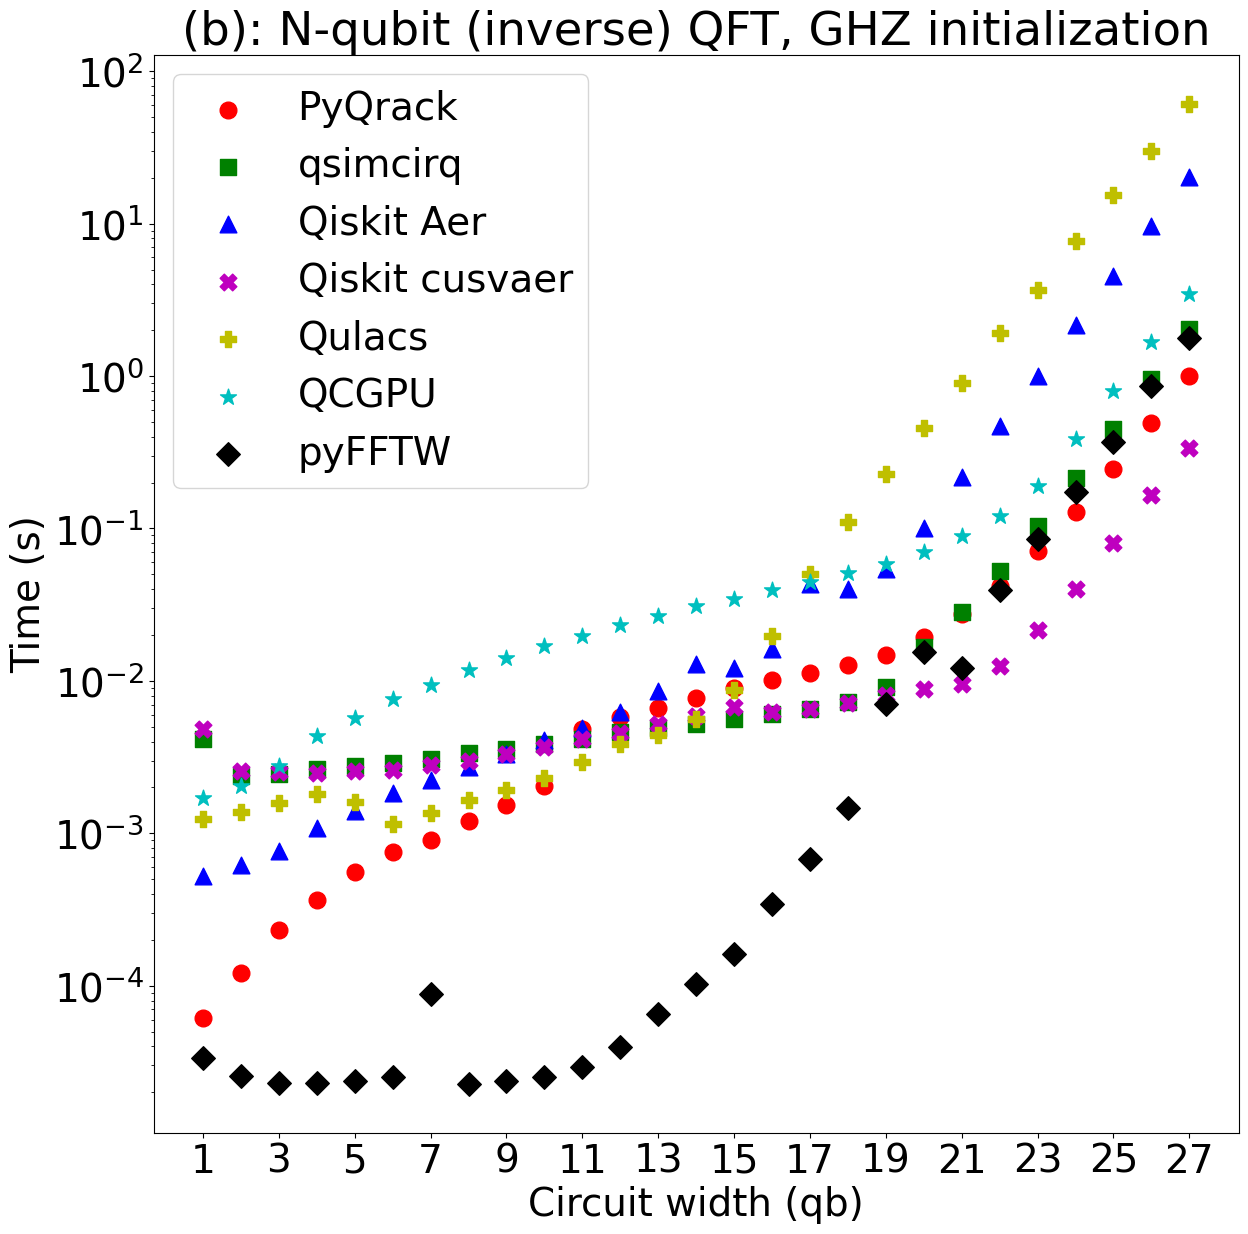

In [23]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc("legend", fontsize=28)
plt.rcParams.update({"font.size": 28, "lines.markersize": 12})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_ghz_results.keys()
y = qrack_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qsimcirq_ghz_results.keys()
y = qsimcirq_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = aer_ghz_results.keys()
y = aer_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = cusvaer_ghz_results.keys()
y = cusvaer_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qulacs_ghz_results.keys()
y = qulacs_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = qcgpu_ghz_results.keys()
y = qcgpu_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

x = fftw_ghz_results.keys()
y = fftw_ghz_results.values()
plt.scatter(x, y, color=colors.pop(), marker=markers.pop())

plt.title("(b): N-qubit (inverse) QFT, GHZ initialization")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack", "qsimcirq", "Qiskit Aer", "Qiskit cusvaer", "Qulacs", "QCGPU", "pyFFTW"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig("qft_ghz_chart.png", dpi=100)

In [24]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
Linux-6.8.0-49-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='6.8.0-49-generic', version='#49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2', machine='x86_64')
Linux
x86_64


In [25]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [29]:
import platform
import subprocess


def get_processor_info():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        return subprocess.check_output(
            ["/usr/sbin/sysctl", "-n", "machdep.cpu.brand_string"]
        ).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        return subprocess.check_output(command, shell=True).strip()
    return ""


get_processor_info()

b'processor\t: 0\nvendor_id\t: GenuineIntel\ncpu family\t: 6\nmodel\t\t: 165\nmodel name\t: Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz\nstepping\t: 2\nmicrocode\t: 0xfc\ncpu MHz\t\t: 4542.119\ncache size\t: 16384 KB\nphysical id\t: 0\nsiblings\t: 16\ncore id\t\t: 0\ncpu cores\t: 8\napicid\t\t: 0\ninitial apicid\t: 0\nfpu\t\t: yes\nfpu_exception\t: yes\ncpuid level\t: 22\nwp\t\t: yes\nflags\t\t: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid mpx rdseed adx smap clflushopt in